In [1]:
import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [2]:
# Get the Horse or Human training dataset
!wget -q -P /content/ https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip

# Get the Horse or Human validation dataset
!wget -q -P /content/ https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip

test_local_zip = './horse-or-human.zip'
zip_ref = zipfile.ZipFile(test_local_zip, 'r')
zip_ref.extractall('/tmp/training')

val_local_zip = './validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(val_local_zip, 'r')
zip_ref.extractall('/tmp/validation')

zip_ref.close()

In [4]:
# Define the training and validation base directories
train_dir = '/tmp/training'
validation_dir = '/tmp/validation'

# Directory with training horse pictures
train_horses_dir = os.path.join(train_dir, 'horses')
# Directory with training humans pictures
train_humans_dir = os.path.join(train_dir, 'humans')
# Directory with validation horse pictures
validation_horses_dir = os.path.join(validation_dir, 'horses')
# Directory with validation human pictures
validation_humans_dir = os.path.join(validation_dir, 'humans')

# Check the number of images for each class and set
print(f"There are {len(os.listdir(train_horses_dir))} images of horses for training.")
print(f"There are {len(os.listdir(train_humans_dir))} images of humans for training.")
print(f"There are {len(os.listdir(validation_horses_dir))} images of horses for validation.")
print(f"There are {len(os.listdir(validation_humans_dir))} images of humans for validation.")

There are 500 images of horses for training.
There are 527 images of humans for training.
There are 128 images of horses for validation.
There are 128 images of humans for validation.


In [6]:
train_datagen = ImageDataGenerator(1/255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=32,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

val_datagen = ImageDataGenerator(1/255)

val_generator = train_datagen.flow_from_directory(validation_dir,
                                                    batch_size=32,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [7]:
# Download the inception v3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2022-03-15 19:39:54--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.125.128, 142.250.157.128, 2404:6800:4008:c01::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   204MB/s    in 0.4s    

2022-03-15 19:39:54 (204 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [8]:
# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [9]:
pre_trained_model = InceptionV3(input_shape=(150, 150, 3),
                                include_top=False,
                                weights=None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False

pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [11]:
def last_layer_output(pre_trained_model):
  last_desired_layer = pre_trained_model.get_layer('mixed7')
  print('last layer output shape: ', last_desired_layer.output_shape)
  last_output = last_desired_layer.output
  print('last layer output: ', last_output)
  
  return last_output

last_output = last_layer_output(pre_trained_model)

last layer output shape:  (None, 7, 7, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")


In [12]:
# Print the type of the pre-trained model
print(f"The pretrained model has type: {type(pre_trained_model)}")

The pretrained model has type: <class 'keras.engine.functional.Functional'>


In [16]:
def create_model(pre_trained_model, last_output):
  x = layers.Flatten()(last_output)
  x = layers.Dense(1024, activation='relu')(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Dense(1, activation='sigmoid')(x)

  model = Model(inputs=pre_trained_model.input, outputs=x)

  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
  
  return model

In [18]:
model = create_model(pre_trained_model, last_output)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                            

In [19]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

In [21]:
callbacks = myCallback()

history = model.fit(train_generator,
                    validation_data = val_generator,
                    epochs = 100,
                    callbacks=callbacks)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100
33/33 [==============================] - 24s 288ms/step - loss: 139.1258 - accuracy: 0.6436 - val_loss: 16.5629 - val_accuracy: 0.9297
Epoch 2/100
33/33 [==============================] - 8s 242ms/step - loss: 9.3151 - accuracy: 0.8656 - val_loss: 8.7427 - val_accuracy: 0.9414
Epoch 3/100
33/33 [==============================] - 8s 234ms/step - loss: 3.5217 - accuracy: 0.9211 - val_loss: 10.9642 - val_accuracy: 0.9297
Epoch 4/100
33/33 [==============================] - 8s 232ms/step - loss: 1.2418 - accuracy: 0.9669 - val_loss: 6.8833 - val_accuracy: 0.9531
Epoch 5/100
33/33 [==============================] - 8s 233ms/step - loss: 0.9855 - accuracy: 0.9601 - val_loss: 3.9291 - val_accuracy: 0.9570
Epoch 6/100
33/33 [==============================] - 8s 235ms/step - loss: 0.5582 - accuracy: 0.9766 - val_loss: 7.0408 - val_accuracy: 0.9219
Epoch 7/100
33/33 [==============================] - 8s 237ms/step - loss: 0.1353 - accuracy: 0.9903 - val_loss: 7.4689 - val_accuracy: 0

In [ ]:
# 1000 color training images
# Transfer learning
# 100 epochs, with 99.9% callback at 19 epochs
# Training time:  ~ 3 min
# Final Train/val accuracy: 1 / 0.95

In [22]:
import matplotlib.pyplot as plt

def create_val_plot(model_history):
        
    model_history = model_history.history

    # Training and validation loss plot
    loss_values = model_history['loss']
    val_loss_values = model_history['val_loss']

    epochs = range(1, len(loss_values) + 1)
    
    plt.figure()
    plt.plot(epochs, loss_values, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss_values, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
        
    # Training and validation accuracy plot
    acc = model_history['accuracy']
    val_acc = model_history['val_accuracy']

    epochs = range(1, len(acc) + 1)
    
    plt.figure()
    plt.plot(epochs, acc, 'bo', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

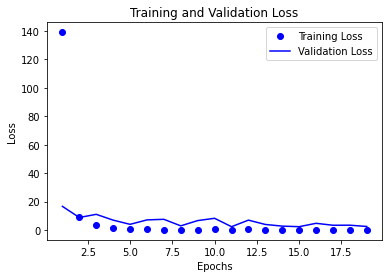

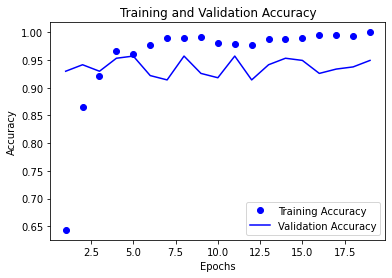

In [23]:
create_val_plot(history)

In [24]:
model.save('horseorhuman_transfer.h5')

In [26]:
import os

def check_model_size(model_path, print_size=True):
    # # Get file size in bytes for a given model
    size = os.stat(model_path).st_size
    if print_size == True:
        print('Model size in bytes ', size)
    else:
        return size

check_model_size('horseorhuman_transfer.h5')

Model size in bytes  499009208


In [27]:
import pandas as pd

def save_training_history(history, filename='model_training_history.csv'):
  history_dict = pd.DataFrame(history.history)
  history_dict.to_csv(filename)

save_training_history(history)

In [39]:
from tensorflow.keras.preprocessing import image
import numpy as np

test_img = 'horse1-000.png'
#test_img = 'valhuman01-03.png'

img = image.load_img(test_img, target_size = (150, 150))
img = image.img_to_array(img)
print('img shape: ', img.shape)

img = img / 255
img = np.expand_dims(img, axis = 0)
print('model input shape: ', img.shape)

prediction = model.predict(img)
print('Model predicted probability: ', prediction)
if prediction <= 0.5:
  print('Image is a horse')
else:
  print('Image is a human')

img shape:  (150, 150, 3)
model input shape:  (1, 150, 150, 3)
Model predicted probability:  [[0.08766456]]
Image is a horse
